In [1]:
%matplotlib inline

In [2]:
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

# import maelstrom as ms
import numpy as np
import corner
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm

In [3]:
kicid = 9651065
times, dmag = np.loadtxt(f"data/kic{kicid}_lc.txt",usecols=(0,1)).T
# Subtract midpoint
time_mid = (times[0] + times[-1]) / 2.
times -= time_mid

# mmags
mags = dmag * 1000. 

metadata = np.loadtxt(f"data/kic{kicid}_metadata.csv", delimiter=",", skiprows=1)
nu_arr = metadata[::6]

# read in the table of orbits
#orbits = pd.read_csv(f"data/orbits.csv").rename(columns = lambda x: x.strip())
#orbits = orbits[orbits.Name == f"kic{kicid}"].iloc[0]

In [4]:
orbits = pd.read_csv(f"data/orbits.csv").rename(columns = lambda x: x.strip())
orbits = orbits[orbits.Name == f"kic{kicid}"].iloc[0]
orbits

Name                   kic9651065
Porb                      272.425
Porb_sig_p               0.296224
Porb_sig_m               0.301695
a1sini/c                  184.557
a1sini/c_sig_p            2.47593
a1sini/c_sig_m            2.56325
e                        0.466711
e_sig_p                  0.021416
e_sig_m                  0.021006
phip                     0.623749
phip_sig_p               0.006471
phip_sig_m               0.006454
varpi                     2.19866
varpi_sig_p              0.042901
varpi_sig_m               0.04211
f(M)Msun                0.0909446
f(M)Msun_sig_p          0.0036658
f(M)Msun_sig_m          0.0037945
gradient                -0.023354
grad_sig_p                0.00303
grad_sig_m               0.003051
t_p                       55128.3
t_p_sig_p                 1.78803
t_p_sig_m                 1.78347
K1_ms                     13063.5
K1_ms_sig_p                 206.9
K1_ms_sig_m                 195.9
median_segment_size           NaN
Name: 290, dty

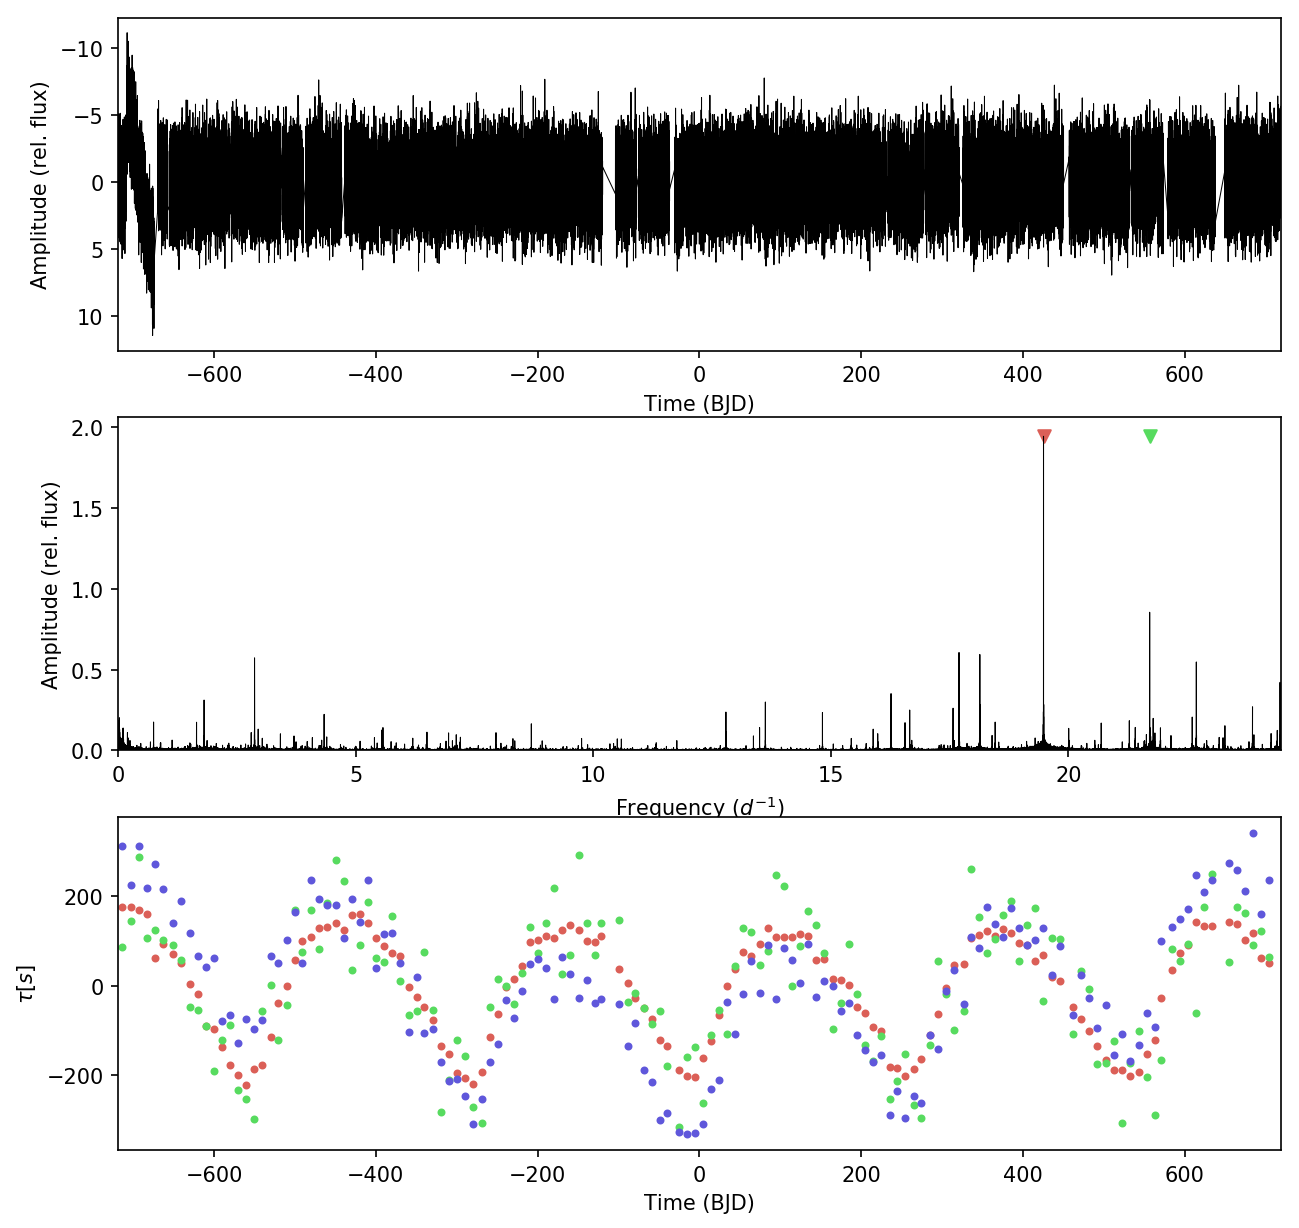

In [5]:
import maelstrom
ms = maelstrom.Maelstrom(times, mags, freq=nu_arr[:3])
ms.setup_orbit_model(period=None)
ms.first_look()

In [6]:
opt = ms.optimize()

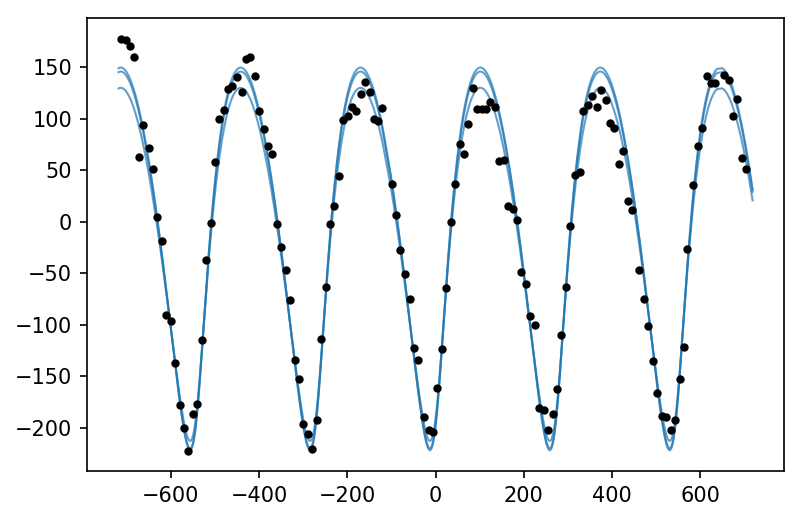

In [8]:
tau = ms.evaluate(ms.tau*86400, opt)
plt.plot(times, tau - np.mean(tau), c="C0", alpha=0.7, lw=1)
a,b = ms.get_time_delay()
plt.plot(a,b[0], ".k")

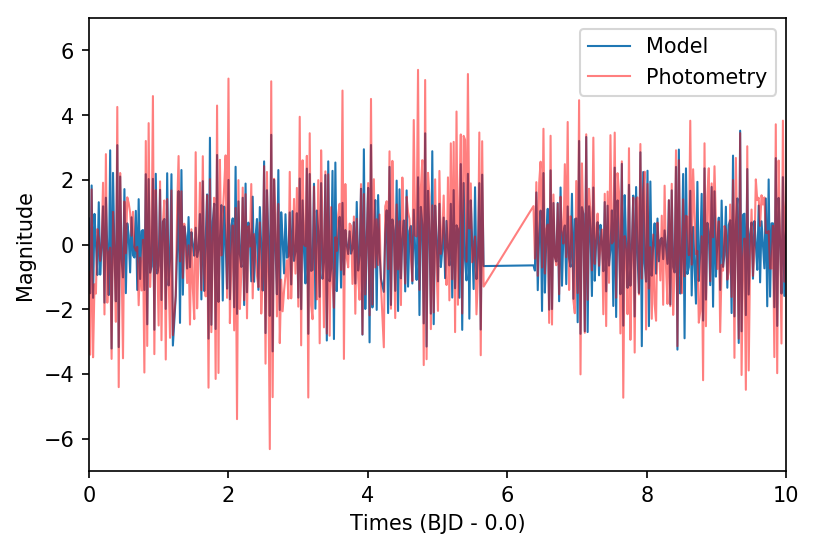

In [9]:
lc_model = ms.evaluate(ms.lc_model, opt)
plt.plot(times, lc_model, c="C0", lw=1, label='Model')
plt.plot(times, mags, alpha=0.5, c='red', lw=1, label='Photometry')

plt.xlim(0,10)
plt.ylim(-7,7)
plt.xlabel('Times (BJD - ' + str(ms.time_mid) + ')')
plt.ylabel('Magnitude')
plt.legend()

In [10]:
pb1_model = ms.pin_orbit_model(opt)

In [11]:
pb1_model

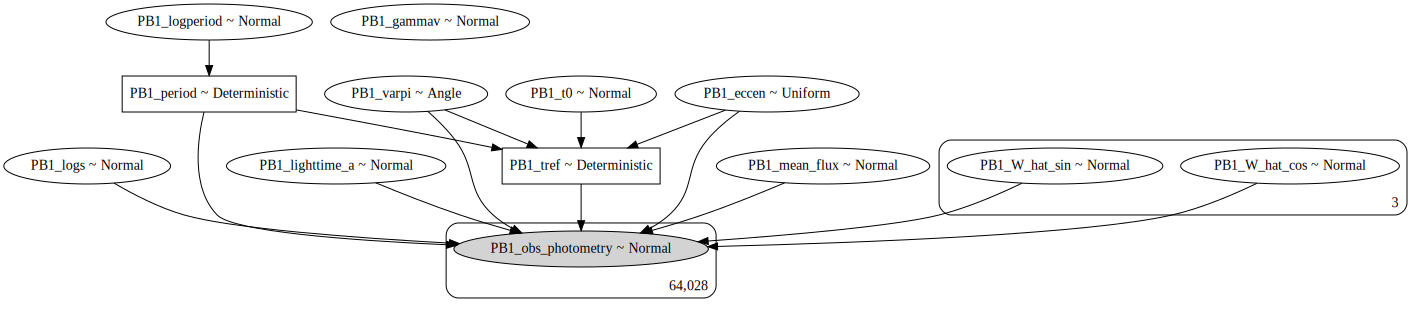

In [12]:
pb1_model.print_model()

In [13]:
opt = pb1_model.optimize()

success: True
initial logp: -139605.6383460548
final logp: -122364.81882685752
success: True
initial logp: -122364.81882685752
final logp: -114847.29422975848
success: True
initial logp: -114847.29422975848
final logp: -114309.57492490987
success: True
initial logp: -114309.57492490987
final logp: -113978.57709778106
success: True
initial logp: -113978.57709778106
final logp: -113978.56018700545
success: False
initial logp: -113978.56018700545
final logp: -113968.00909916963
success: True
initial logp: -113968.00909916963
final logp: -113967.57757012264
success: True
initial logp: -113967.57757012264
final logp: -113680.44631391564
success: False
initial logp: -113680.44631391564
final logp: -113580.06346917957
success: True
initial logp: -113580.06346917957
final logp: -113576.26022877572
success: False
initial logp: -113576.26022877572
final logp: -113489.30296633457


In [14]:
opt

{'PB1_logperiod': array(5.60484374),
 'PB1_t0': array(-7.83160765),
 'PB1_varpi_angle__': array([-1.10137488e-05,  1.45495077e-05]),
 'PB1_eccen_interval__': array(-0.20458336),
 'PB1_logs': array(0.35247282),
 'PB1_lighttime_a': array(183.72778611),
 'PB1_gammav': array(0.),
 'PB1_mean_flux': array(-0.00088768),
 'PB1_W_hat_cos': array([ 1.62988417,  0.07216878, -0.54453484]),
 'PB1_W_hat_sin': array([-1.07791633, -0.86448818, -0.48590478]),
 'PB1_period': array(271.73945932),
 'PB1_varpi': array(2.21875242),
 'PB1_eccen': array(0.44903283),
 'PB1_tref': array(2.1178471)}

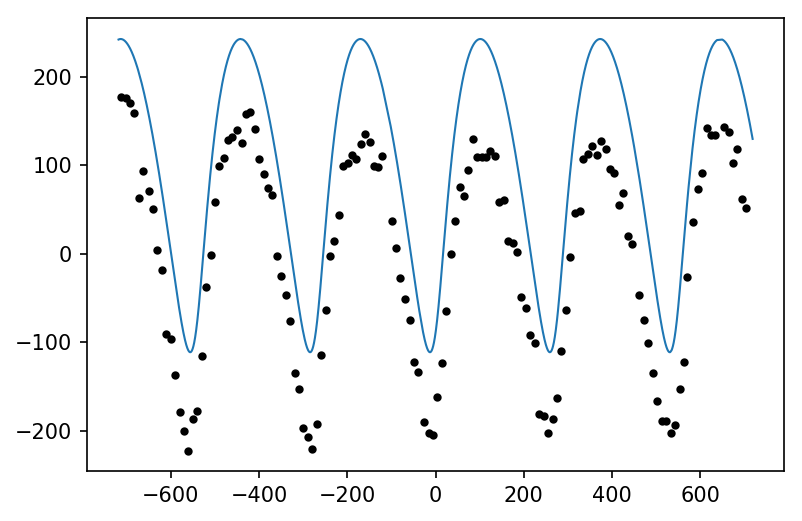

In [15]:
plt.plot(times, pb1_model.evaluate(pb1_model.tau*86400, opt), c="C0", alpha=1, lw=1)
a,b = pb1_model.get_time_delay()
plt.plot(a,b[0], ".k")

In [16]:
trace = pb1_model.sample(tune=1000, draws=1000, start=opt)

Sampling 2 chains: 100%|██████████| 1204/1204 [25:24<00:00,  1.53draws/s]
The chain contains only diverging samples. The model is probably misspecified.
Sampling 2 chains:   5%|▍         | 28/604 [01:39<42:32,  4.43s/draws]


ValueError: Not enough samples to build a trace.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2de18d68>,
      dtype=object)

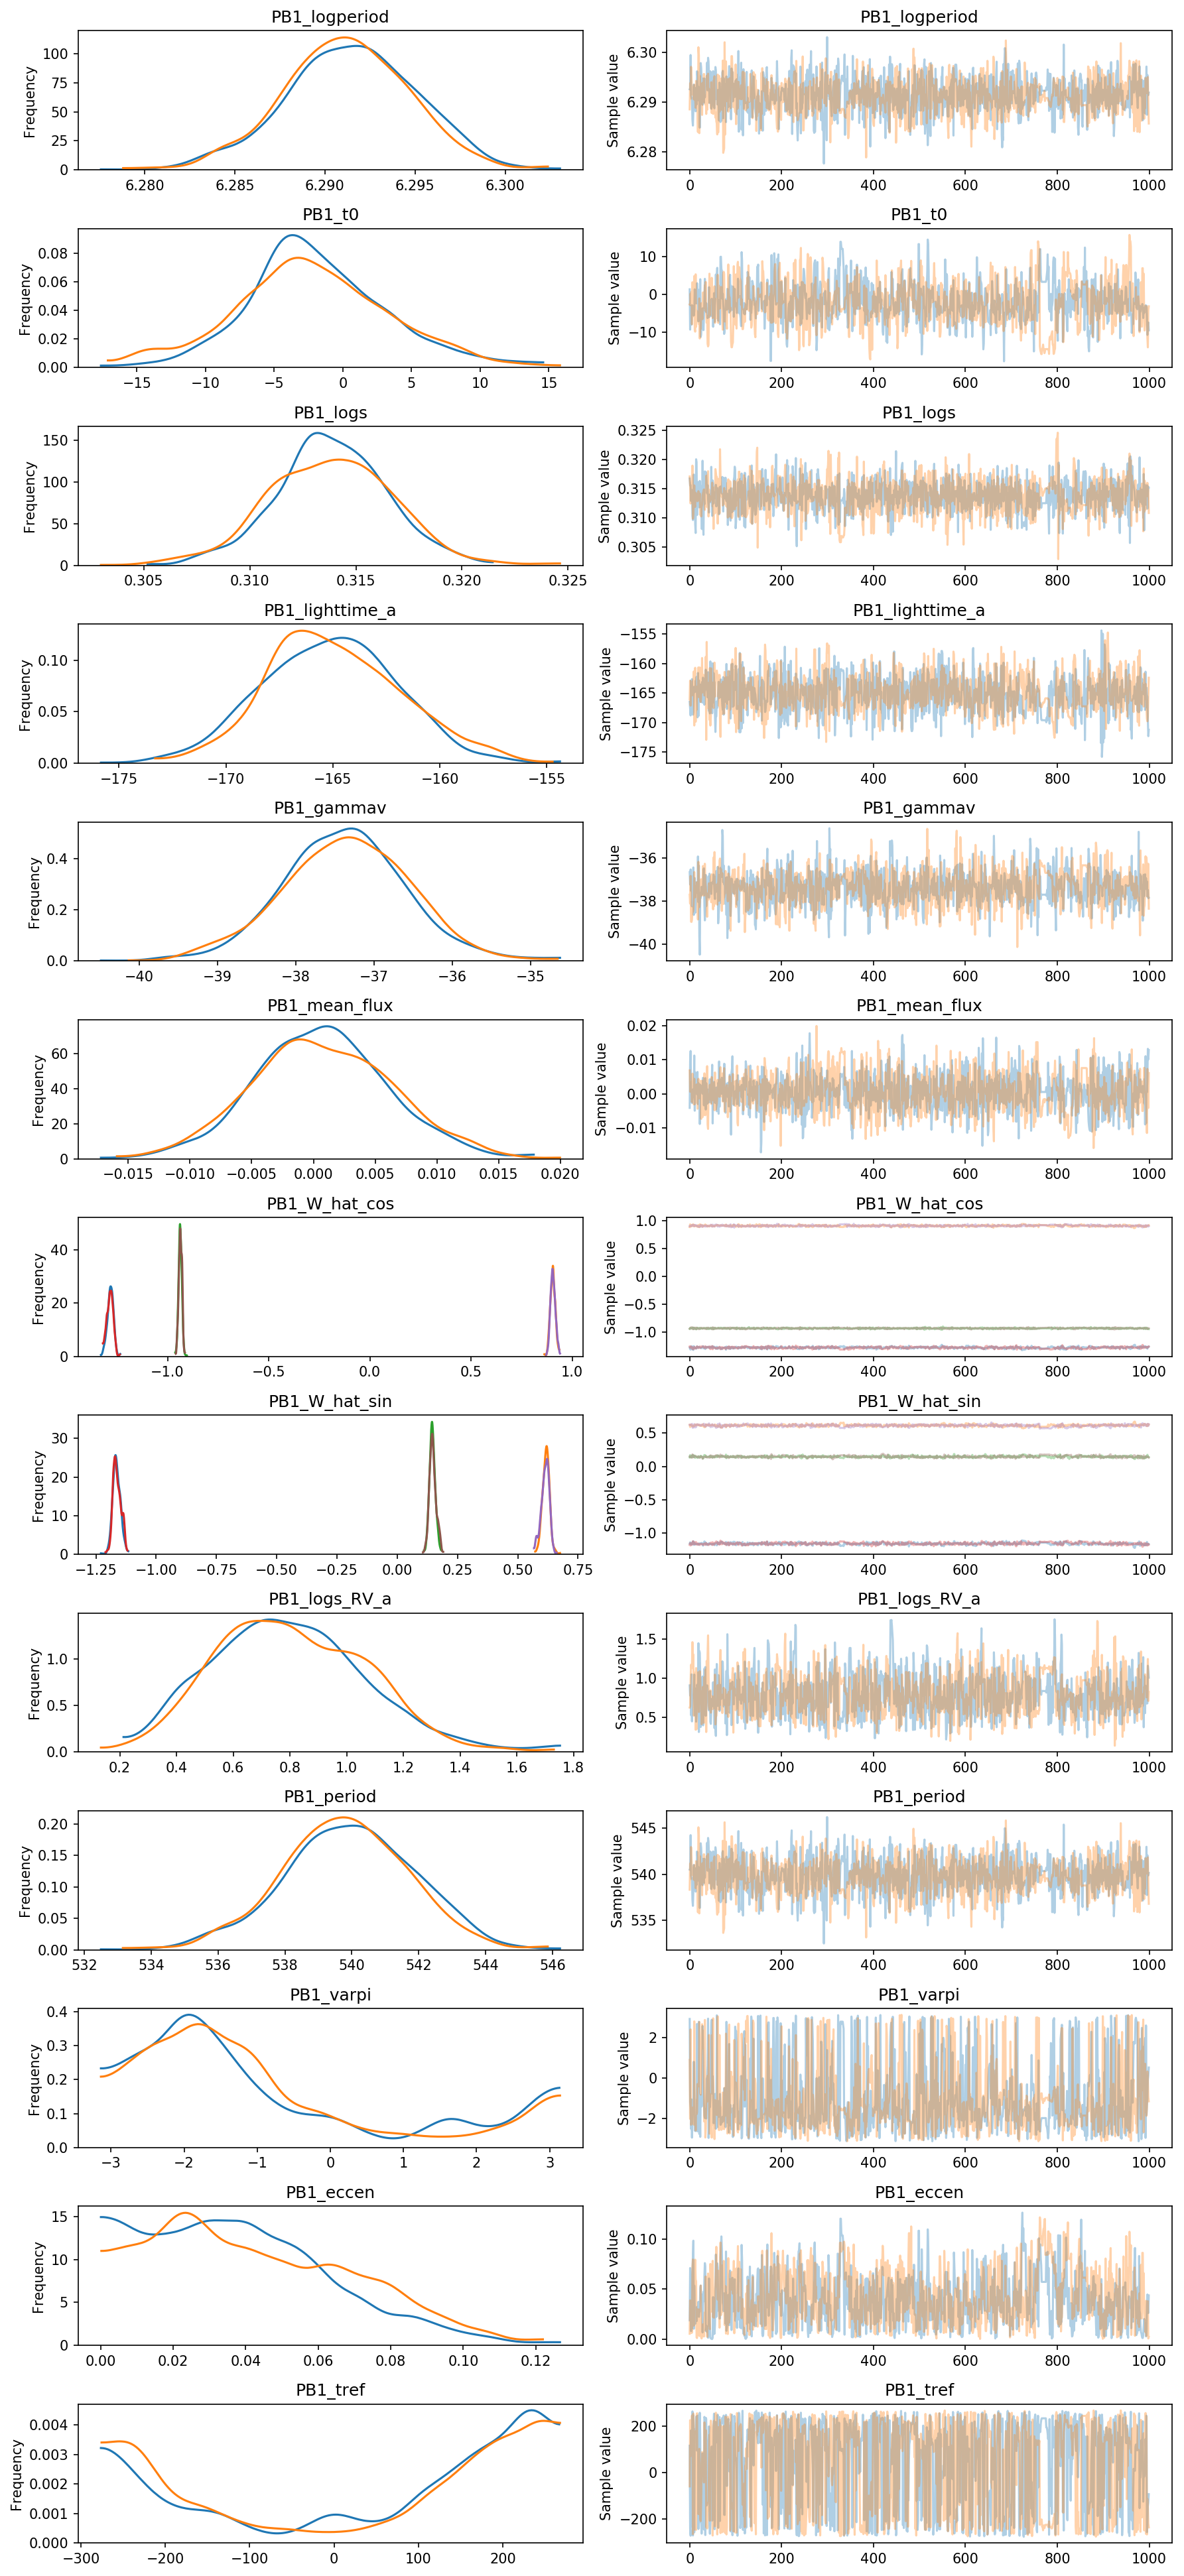

In [19]:
import pymc3 as pm
pm.traceplot(trace)